# Introduction

This is a walk-through of building a Risk-Based Prioritization Decision Tree based on [CISA SSVC](https://resources.sei.cmu.edu/asset_files/WhitePaper/2021_019_001_653461.pdf), from scratch, in code.

Risk is per Asset and depends on Impact of a Vulnerability being exploited by a Threat per [NIST Special Publication 800-30 r1 Guide for Conducting Risk Assessments ](https://nvlpubs.nist.gov/nistpubs/legacy/sp/nistspecialpublication800-30r1pdf).

One approach to assess risk is to do multiple passes - starting with a first pass triage of vulnerabilites
1. First pass: Prioritize Vulnerabilities in an automated way independent of Asset
   1. Given a list of vulnerabilities, prioritize them given what we know about the vulnerability from multiple data sources (independent of the assets i.e. assume a generic asset for risk purposes for this first pass). 
2. Second pass: Dependent on Asset
   1. There can be MANY independent parameters that determine the risk associated with an Asset e.g.
      1. Value
      2. Exposure e.g. open (to the internet)
      3. Reachability - is the vulnerable method called
      4. Compensating controls
      5. Underlying Stack component versions in place e.g. SpringShell Spring Framework exploitability depends on certain JDK versions.
   2. Many of these parameters are generic for the vulnerabilities associated with the Asset - and are known in advance and fixed e.g. Asset Value, Asset Exposure.
   3. Some of the parameters will depend on the specific vulnerability and the pre-conditions it needs to implement the full kill-chain. E.g. exploitable depending on the configuration or runtime context of the vulnerable software.

This 2 pass approach allows us to first determine the highest priority vulnerabilities - and then assess these against our highest value/exposure assets.

**We'll walk through this First Pass triage - using a Decision Tree to prioritze the vulnerabilities.**
* **We'll build this Decision Tree from scratch.**
* **An extract of the data is shown for each step. So we can see what's happening without needing to understand the code**
* A key benfit to Decision Trees is that they are understandable. The implementation of them should support that too. So the code here aims for clarity e.g. laid out inline.

The recipe:
1. Get enriched NVD CVE data  
   1. Do some minimal Exploit Data Sources Exploratory Data Analysis (EDA) to better understand the data
2. Build a Decision Tree
3. Find the Decisions (Prioritization) for some vulnerabilities with CVEs
   1. Note that the same logic can be applied to vulnerabilities without CVEs.
4. Visualize the flow / distribution of vulnerabilites across our Decision Tree branches
5. Validate our Decision Tree using Decision Tree Analysis

**Note: this enriched data can be used for any risk prioritization scheme i.e. not specific to SSVC.**
* **It could be used to inform [CVSS Exploit Maturity (E)](https://www.first.org/cvss/v4.0/specification-document#Exploit-Maturity-E)**


*TL;DR: Blah, Blah, Blah... How do I build and automate a Decision Tree to do a first pass triage of vulnerabilities?*


## Starting Point
Most recent first:
1. [Using Decision Trees for Vulnerability Prioritization With SSVC](https://www.youtube.com/watch?v=25RHdcSwHCg&t=3532s), August 2023
2. [Understanding Your Vulnerability Data To Optimize Your DevOps Pipeline Flow](https://www.youtube.com/watch?v=oMZN810xfck) May 2023 defines a Risk Taxonomy and shows how we connected the Risk Data sources together into a CISA SSVC DT and how we use the DT as a first pass triage of vulnerabilities.
   1. https://github.com/theparanoids/PrioritizedRiskRemediation has the deck, diagrams.
3. CISA SSVC
   1. [SEI CMU Prioritizing Vulnerability Response: A Stakeholder-Specific Vulnerability Categorization (Version 2.1.0-draft 2023-09-01)](https://github.com/CERTCC/SSVC/blob/main/draft/ssvc.pdf)
   2. https://www.first.org/resources/papers/conf2022/121_04-PrioritizingVulnerability-Spring.pdf Good presentation on DTs for SSVC, 2022
   3. [SEI CMU Prioritizing Vulnerability Response: A Stakeholder-Specific Vulnerability Categorization (Version 2.0)](https://resources.sei.cmu.edu/library/asset-view.cfm?assetid=653459), 2021
   4. https://github.com/CERTCC/SSVC

In [158]:
# Need these for the DT logic
import pandas as pd

# Need these for the plots
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from IPython.display import Image #to display images in github from this notebook


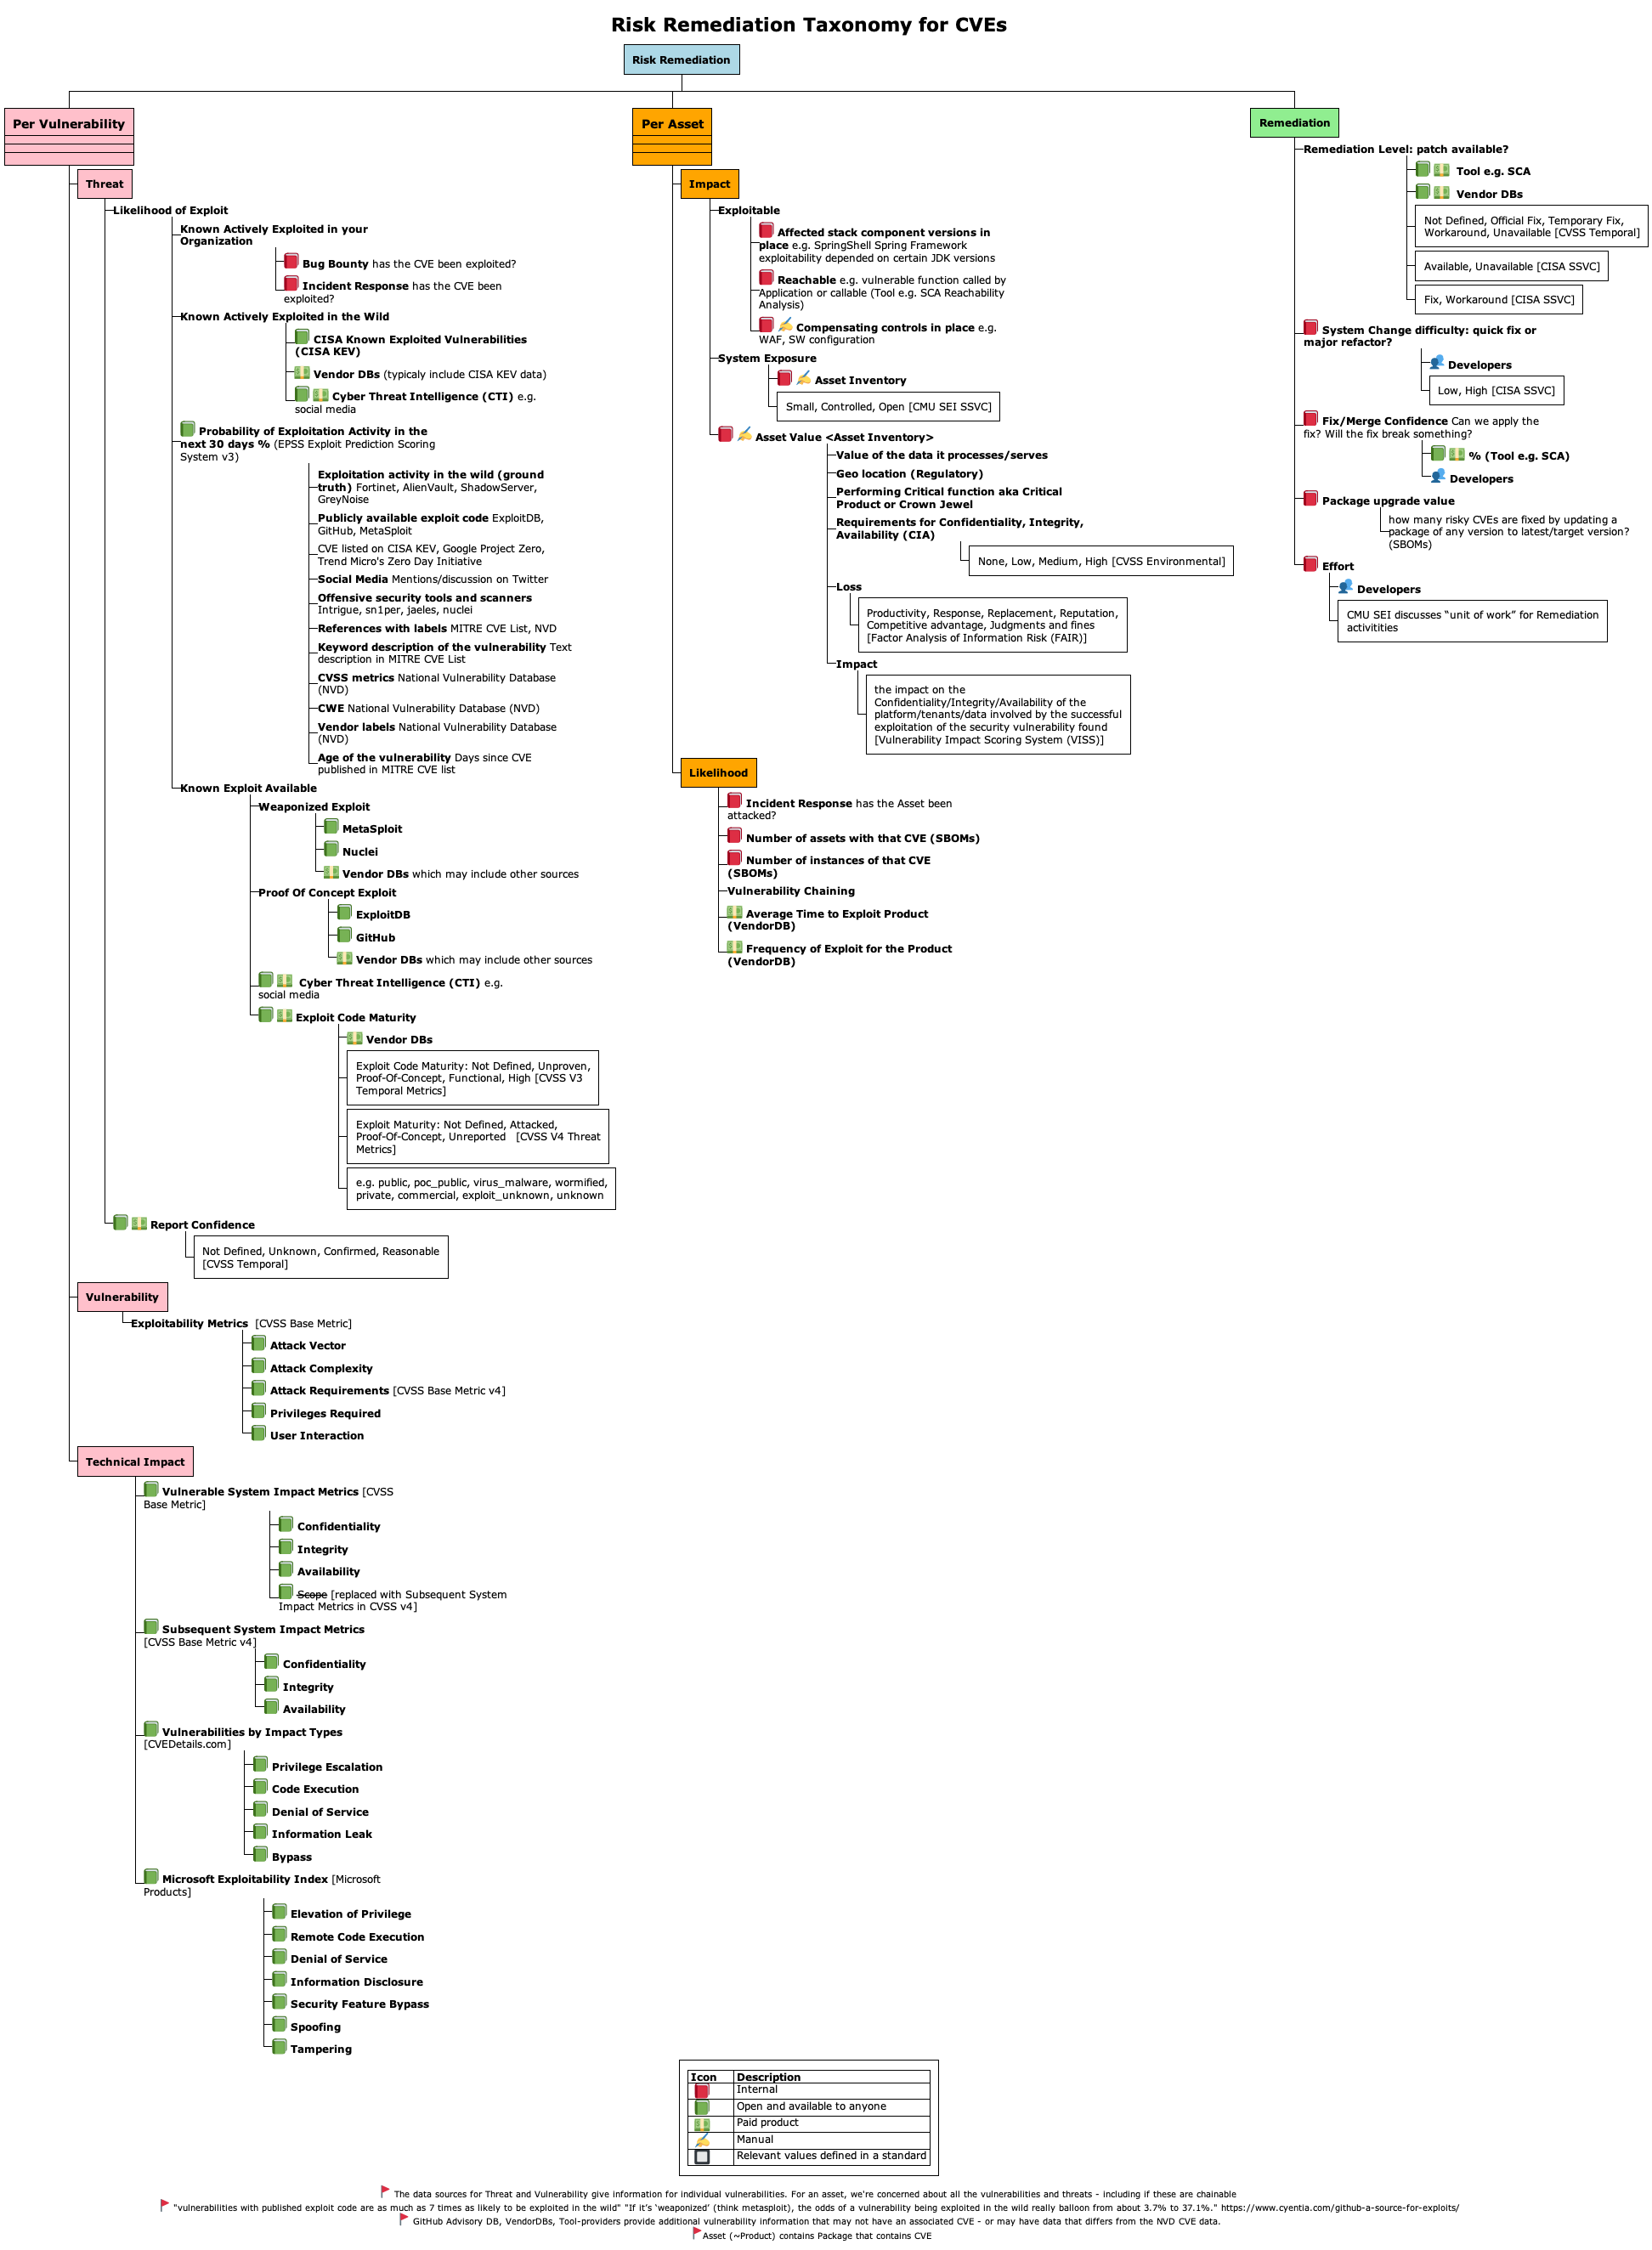

In [199]:
Image(filename='../images/RiskRemediation.png') 


In [160]:
cve_list_df = pd.read_csv('../data_out/CVSSData_enriched.csv.gz', compression="gzip")
cve_list_df

,cve,Published,Description,AttackVector CVSS3,AttackComplexity CVSS3,PrivilegesRequired CVSS3,UserInteraction CVSS3,Scope CVSS3,ConfidentialityImpact CVSS3,IntegrityImpact CVSS3,...,CWEs,metasploit,nuclei,epss,exploitdb,cisa_kev,msrc,gpz,exploit,BaseScore
0,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,['NVD-CWE-Other'],False,False,0.01157,False,False,False,False,5,10.0
1,CVE-1999-0082,1988-11-11,CWD ~root command in ftpd allows root access.,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,['NVD-CWE-Other'],False,False,0.11698,False,False,False,False,5,10.0
2,CVE-1999-1471,1989-01-01,Buffer overflow in passwd in BSD based operati...,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,['NVD-CWE-Other'],False,False,0.00043,False,False,False,False,5,7.2
3,CVE-1999-1122,1989-07-26,Vulnerability in restore in SunOS 4.0.3 and ea...,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,['NVD-CWE-Other'],False,False,0.00061,False,False,False,False,5,4.6
4,CVE-1999-1467,1989-10-26,Vulnerability in rcp on SunOS 4.0.x allows rem...,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,['NVD-CWE-Other'],False,False,0.00425,False,False,False,False,5,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221301,CVE-2023-40411,2024-01-10,This issue was addressed with improved data pr...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,['NVD-CWE-noinfo'],False,False,0.00000,False,False,False,False,5,5.5
221302,CVE-2023-42826,2024-01-10,The issue was addressed with improved checks. ...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,...,['NVD-CWE-noinfo'],False,False,0.00000,False,False,False,False,5,7.8
221303,CVE-2023-41987,2024-01-10,This issue was addressed with improved checks....,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,['NVD-CWE-noinfo'],False,False,0.00000,False,False,False,False,5,5.5
221304,CVE-2023-41994,2024-01-10,A logic issue was addressed with improved chec...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,['NVD-CWE-noinfo'],False,False,0.00000,False,False,False,False,5,5.5


## Data Housekeeping


### Optimize columns that contain categories of data
e.g. confidentialityImpact has categories: HIGH, LOW, NONE

In [161]:
# Create a dictionary to map old column names to new column names
column_mapping = {'AttackComplexity CVSS3': 'attackComplexity',
                  'AttackVector CVSS3': 'attackVector',
                  'UserInteraction CVSS3': 'userInteraction',
                  'PrivilegesRequired CVSS3': 'privilegesRequired',                  
                  'AvailabilityImpact CVSS3': 'availabilityImpact',
                  'ConfidentialityImpact CVSS3': 'confidentialityImpact',   
                  'IntegrityImpact CVSS3': 'integrityImpact'}

# Rename columns using the rename() method
cve_list_df.rename(columns=column_mapping, inplace=True)

In [162]:
cve_list_df = cve_list_df.astype({"attackComplexity":'category', "attackVector":'category',  "userInteraction":'category', "privilegesRequired":'category', "availabilityImpact":'category', "confidentialityImpact":'category', "integrityImpact":'category', "epss":'float64'})

cve_list_df.dtypes

cve                              object
Published                        object
Description                      object
attackVector                   category
attackComplexity               category
privilegesRequired             category
userInteraction                category
Scope CVSS3                      object
confidentialityImpact          category
integrityImpact                category
availabilityImpact             category
BaseScore CVSS3                 float64
BaseSeverity CVSS3               object
ExploitabilityScore CVSS3       float64
ImpactScore CVSS3               float64
AccessVector CVSS2               object
AccessComplexity CVSS2           object
Authentication CVSS2             object
ConfidentialityImpact CVSS2      object
IntegrityImpact CVSS2            object
AvailabilityImpact CVSS2         object
BaseScore CVSS2                 float64
BaseSeverity CVSS2               object
ExploitabilityScore CVSS2       float64
ImpactScore CVSS2               float64


# Define the Decision Tree
CISA Coordinator v2.0.3 https://www.cisa.gov/ssvc-calculator





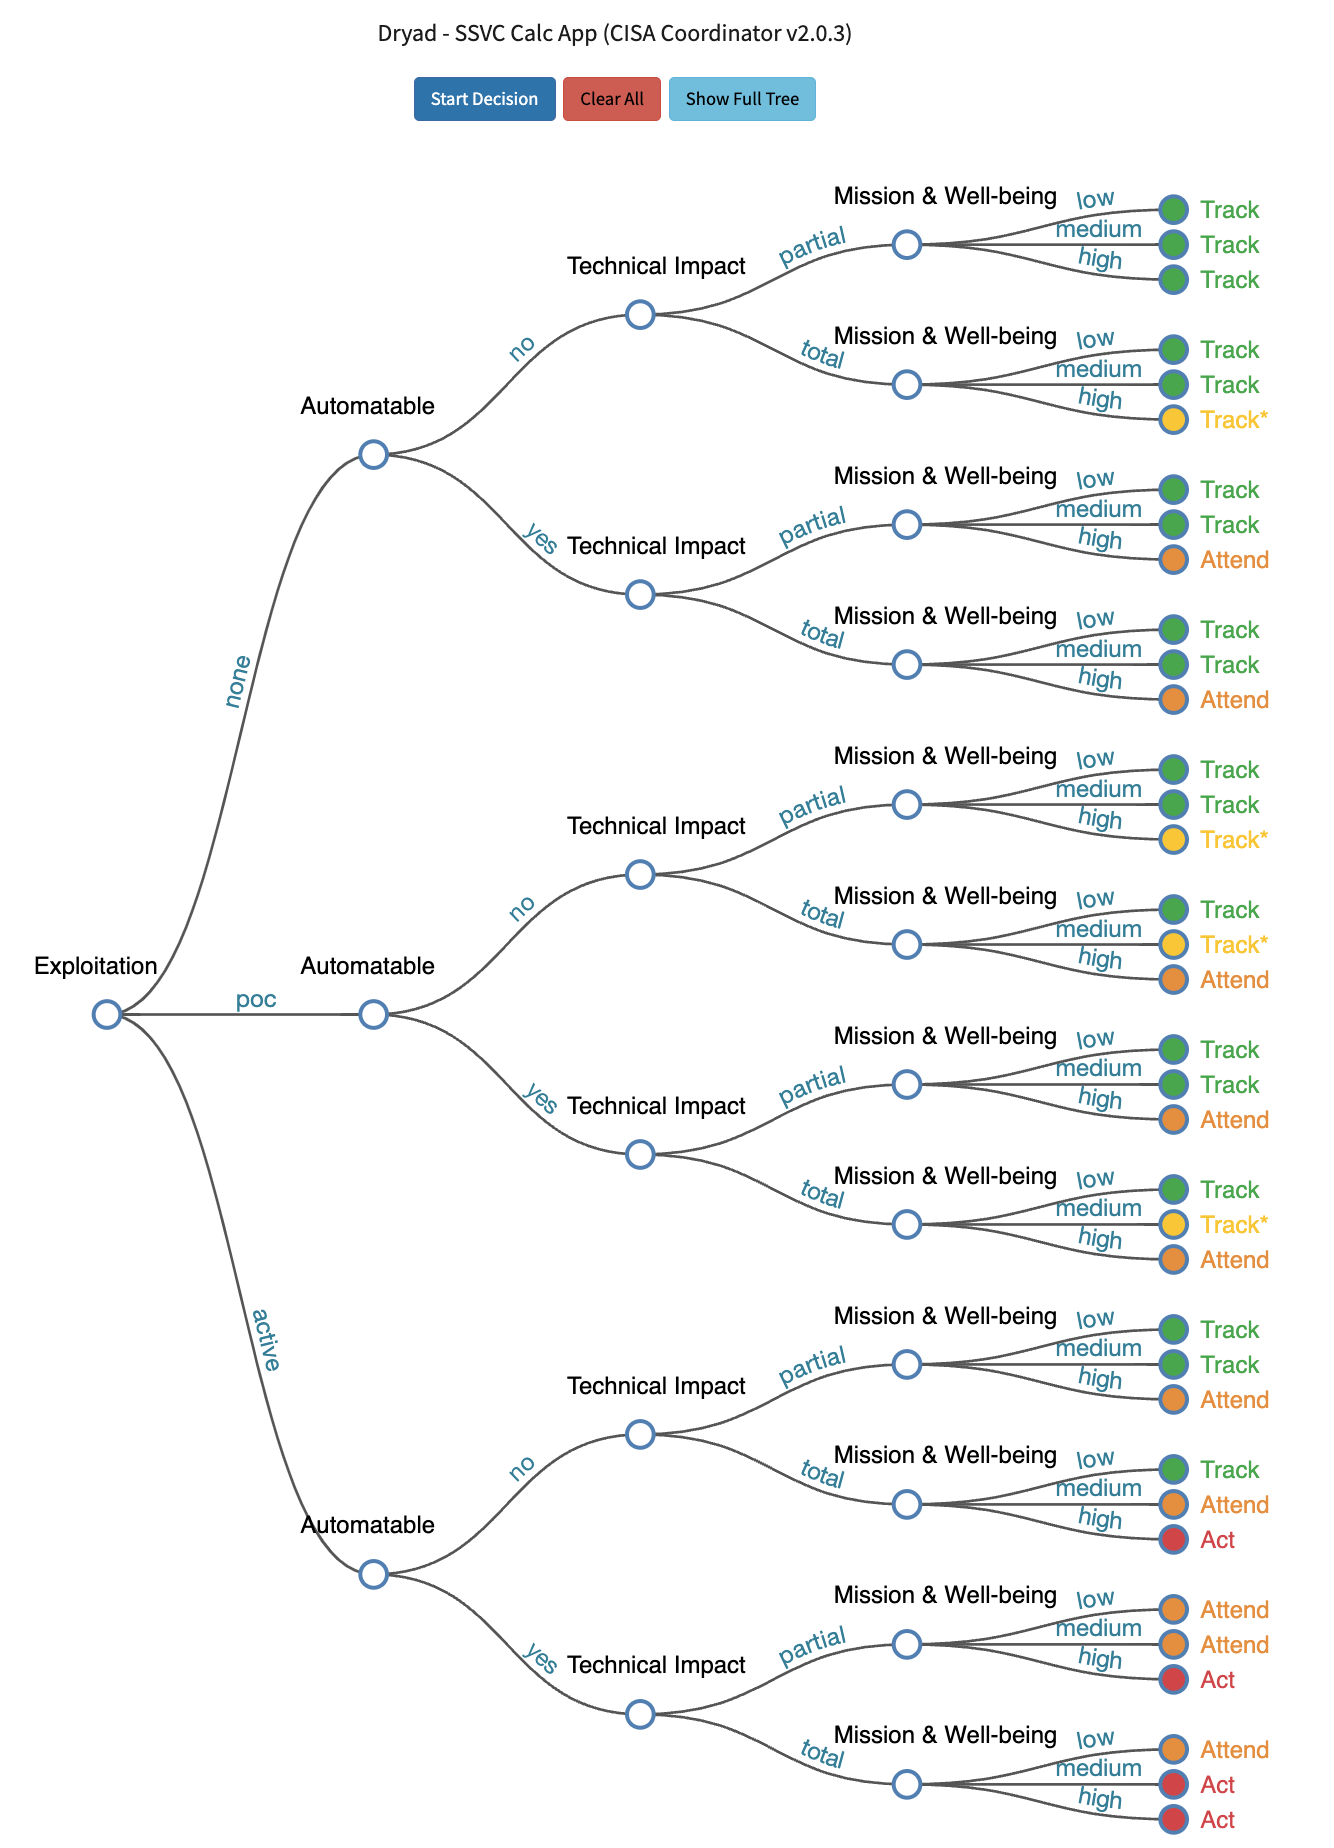

In [163]:
Image(filename='../images/DT_CISA_SSVC.png') 

In [164]:
# The CISA SSVC DT is codified as a CSV file - each row represents a possible full path through the tree.
# 36 paths/leaves in total: 3 x 2 x 2 x 3
# The Leaf column allows us to keep track of what leaf in the DT is associated with a Decision later on (where there are 36 leaves, but these are mapped to 5 Priorities: Act, Attend,...)
dt_df = pd.read_csv('./DT_rbp.csv')

dt_df

,Leaf,Exploitation,Automatable,TechnicalImpact,MissionWellBeing,Priority
0,1,active,yes,total,high,Act
1,2,active,yes,total,medium,Act
2,3,active,yes,total,low,Attend
3,4,active,yes,partial,high,Act
4,5,active,yes,partial,medium,Attend
5,6,active,yes,partial,low,Attend
6,7,active,no,total,high,Act
7,8,active,no,total,medium,Attend
8,9,active,no,total,low,Track
9,10,active,no,partial,high,Attend


# Define the Decision Logic for the Decision Nodes

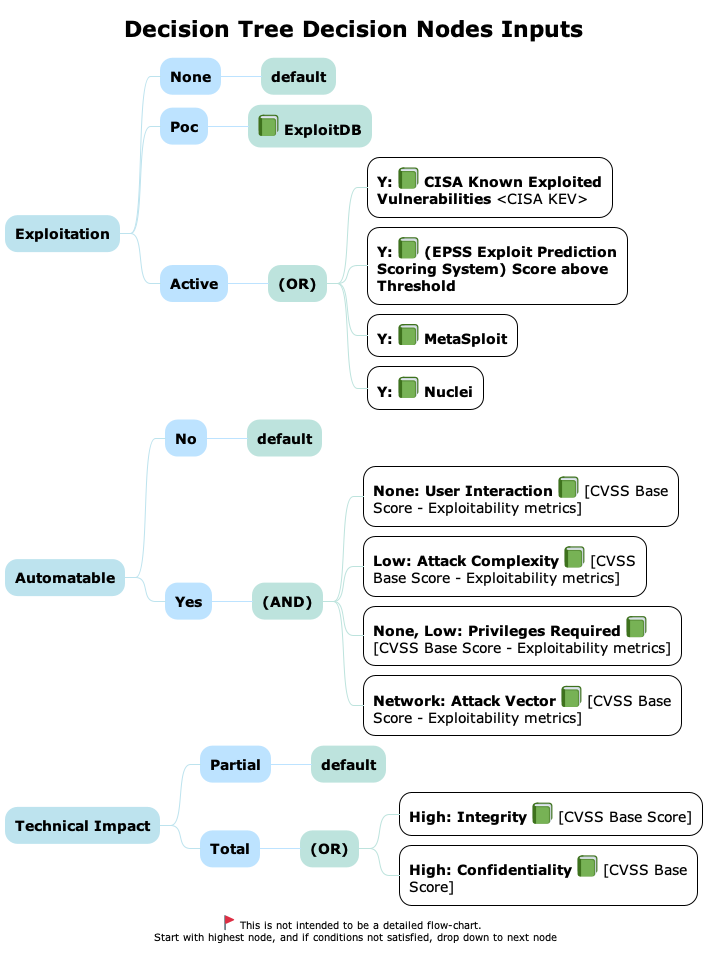

In [165]:
Image(filename='../images/DT_decisions.png') 


A reference for Decision Tree Decision logic and Data Sources: https://github.com/theparanoids/PrioritizedRiskRemediation#risk-based-decision-tree-decisions

In this example, we will use the DT as a first pass automated triage of vulnerabilities, independent of asset business/runtime/remediation context.

**Exploitation**
1. “EPSS could be used to inform the Exploitation decision point. Currently, Exploitation focuses on the observable state of the world at the time of the SSVC decision. EPSS is about predicting if a transition will occur from the SSVC state of none to active. A sufficiently high EPSS score could therefore be used as an additional criterion for scoring a vulnerability as active even when there is no observed active exploitation.” [SEI CMU Prioritizing Vulnerability Response: A Stakeholder-Specific Vulnerability Categorization (Version 2.0)](https://resources.sei.cmu.edu/library/asset-view.cfm?assetid=653459)
2. "EPSS should be thought of as pre-threat intelligence. Our detection systems, and by extension our threat intelligence, only report what they are programmed to look for, and then only what they can observe. For any given time period, vulnerability feeds can only describe a vulnerability in one of two ways, either it is known to be actively exploited or we don’t know because we haven’t observed exploitation, and absence of evidence is not the evidence of absence. If there is evidence that a vulnerability is being exploited, then that information should supersede anything EPSS has to say, because again, EPSS is pre-threat intel. If there is an absence of exploitation evidence, then EPSS can be used to estimate the probability it will be exploited. In other words, EPSS works best just below the obvious." [EPSS FAQ](https://www.first.org/epss/faq)
3. Exploitation
   1. Active: if in CISA KEV OR EPSS above Threshold or if in Metasploit OR Nuclei
   2. Poc: if in ExploitDB
   3. None: else None

**Automatable**
1. Given this is a first pass automated triage of vulnerabilities we will 
   1. only consider the automatability of the vulnerability based on the CVE Base Score Exploitability Metrics. All 4 conditions must be met.
   2. NOT consider the kill-chain in the context of a specific Asset instance - because this can be done in a second pass (after the first pass triage of vulnerabilities).
2. “If the vulnerability allows remote code execution or command injection, the expected response should be yes.”, Section "Automatable" [SEI CMU Prioritizing Vulnerability Response: A Stakeholder-Specific Vulnerability Categorization (Version 2.0)](https://resources.sei.cmu.edu/library/asset-view.cfm?assetid=653459). It is technically possible to determine if a CVE is of type remote code execution or command injection from the CVE text description using a regex and/or an NLP Classifier. For clarify we will not implement this logic here.
3. Steps 1-4 of the kill-chain depends on the asset context. 

**Technical Impact**
1. CVSS Base Score Technical Impact has 3 parameters: 
   1. Confidentiality, Integrity, Availability. 
   2. And these have 3 values: HIGH, LOW, NONE
1. "Technical impact: partial/total is decided regarding the system scope definition, which considers a database or a web server program as the “whole” system. Furthermore, “total” also includes any technical impact that exposes authentication credentials to the adversary, if those credentials are to the whole system." [SEI CMU Prioritizing Vulnerability Response: A Stakeholder-Specific Vulnerability Categorization (Version 2.0)](https://resources.sei.cmu.edu/library/asset-view.cfm?assetid=653459)
2. CVSS Base Score Scope is not used here for our prioritization in this example
3. Technical Impact is Total if Confidentiality OR Integrity are HIGH

In [166]:

EPSS_THRESHOLD_HIGH = 0.95 #0.95 is used in https://github.com/jgamblin/patchthisapp/blob/main/patchthisapp.ipynb
EPSS_THRESHOLD_LOW = 0.1 #as described in presentation in https://github.com/theparanoids/PrioritizedRiskRemediation 

# 2 different example implementations are shown - specifically around whether weaponized exploits (metasploit, nuclei) should be treated as Exploitation "active" or "PoC"
# Weaponized exploits are somewhere in betweeen i.e. they are more than a PoC and some are likely to become active exploits in the future.
def exploitation_dt1(cisa_kev, epss, metasploit, nuclei, exploitdb):
    if (cisa_kev | (epss >= EPSS_THRESHOLD_LOW)):
        return "active"
    elif (metasploit | nuclei | exploitdb):
        return "PoC"
    else:
        return "none"

def exploitation_dt2(cisa_kev, epss, metasploit, nuclei, exploitdb):
    if (cisa_kev | (epss >= EPSS_THRESHOLD_LOW) | metasploit | nuclei):
        return "active"
    elif (exploitdb):
        return "PoC"
    else:
        return "none"


In [167]:
def automatable_dt(userInteraction, attackComplexity, privilegesRequired, attackVector):    
    if ((userInteraction == 'NONE') & (attackComplexity == 'LOW') & (privilegesRequired != 'HIGH') & (attackVector == 'NETWORK')):
        return "yes"
    else:
        return "no"

In [168]:
def technical_impact_dt(confidentialityImpact, integrityImpact):
    if ((confidentialityImpact == 'HIGH') | (integrityImpact == 'HIGH')):
        return "total"
    else:
        return "partial"

# Calculate the Decisions for all CVEs


### Calculate the Decision Node Values

The DT Decision Nodes are:
1. Exploitation
2. Automatable
3. TechnicalImpact
4. MissionWellBeing - we'll show Decisons for all 3 values since we won't be calculating this now

In [169]:
cve_list_df['Exploitation'] = cve_list_df.apply(lambda x: exploitation_dt2(x['cisa_kev'], x['epss'], x['metasploit'], x['nuclei'], x['exploitdb']), axis=1)

cve_list_df['Automatable'] = cve_list_df.apply(lambda x: automatable_dt(x['userInteraction'], x['attackComplexity'], x['privilegesRequired'], x['attackVector']), axis=1)

cve_list_df['TechnicalImpact'] = cve_list_df.apply(lambda x: technical_impact_dt(x['confidentialityImpact'], x['integrityImpact']), axis=1)

cve_list_df

,cve,Published,Description,attackVector,attackComplexity,privilegesRequired,userInteraction,Scope CVSS3,confidentialityImpact,integrityImpact,...,epss,exploitdb,cisa_kev,msrc,gpz,exploit,BaseScore,Exploitation,Automatable,TechnicalImpact
0,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,0.01157,False,False,False,False,5,10.0,none,no,partial
1,CVE-1999-0082,1988-11-11,CWD ~root command in ftpd allows root access.,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,0.11698,False,False,False,False,5,10.0,active,no,partial
2,CVE-1999-1471,1989-01-01,Buffer overflow in passwd in BSD based operati...,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,0.00043,False,False,False,False,5,7.2,none,no,partial
3,CVE-1999-1122,1989-07-26,Vulnerability in restore in SunOS 4.0.3 and ea...,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,0.00061,False,False,False,False,5,4.6,none,no,partial
4,CVE-1999-1467,1989-10-26,Vulnerability in rcp on SunOS 4.0.x allows rem...,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,0.00425,False,False,False,False,5,10.0,none,no,partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221301,CVE-2023-40411,2024-01-10,This issue was addressed with improved data pr...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,0.00000,False,False,False,False,5,5.5,none,no,total
221302,CVE-2023-42826,2024-01-10,The issue was addressed with improved checks. ...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,...,0.00000,False,False,False,False,5,7.8,none,no,total
221303,CVE-2023-41987,2024-01-10,This issue was addressed with improved checks....,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,0.00000,False,False,False,False,5,5.5,none,no,total
221304,CVE-2023-41994,2024-01-10,A logic issue was addressed with improved chec...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,0.00000,False,False,False,False,5,5.5,none,no,total


In [170]:
cve_list_df['Exploitation'].value_counts()

none      206302
active     15004
Name: Exploitation, dtype: int64

In [171]:
cve_list_df['Automatable'].value_counts()

no     161065
yes     60241
Name: Automatable, dtype: int64

In [172]:
cve_list_df['TechnicalImpact'].value_counts()

partial    127440
total       93866
Name: TechnicalImpact, dtype: int64

In [198]:
cve_list_df.to_csv('../data_out/cisa_ssvc_dt/cvssv3_cves_enriched_dtn.csv.gz', compression="gzip")

### Exploit Data Sources Exploratory Data Analysis



In [174]:
set_cves_exploitation = set(cve_list_df[cve_list_df['Exploitation'] == 'active'].cve)
set_cves_automatable = set(cve_list_df[cve_list_df['Automatable'] == 'yes'].cve)
set_cves_technicalimpact = set(cve_list_df[cve_list_df['TechnicalImpact'] == "total"].cve)
set_cves_epss_01 = set(cve_list_df[cve_list_df['epss'] >= 0.1].cve)
set_cves_nvd = set(cve_list_df.cve)

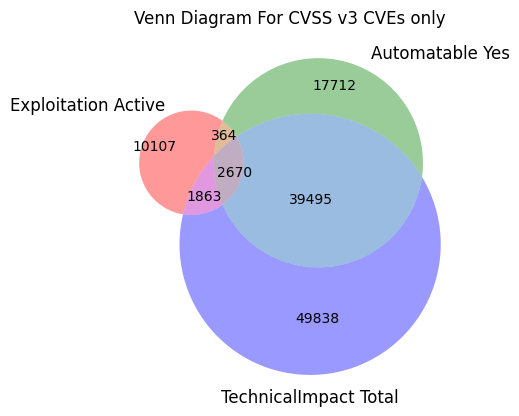

In [175]:
plt.title("Venn Diagram For CVSS v3 CVEs only")

venn3([set_cves_exploitation, set_cves_automatable, set_cves_technicalimpact], ('Exploitation Active', 'Automatable Yes', 'TechnicalImpact Total'))

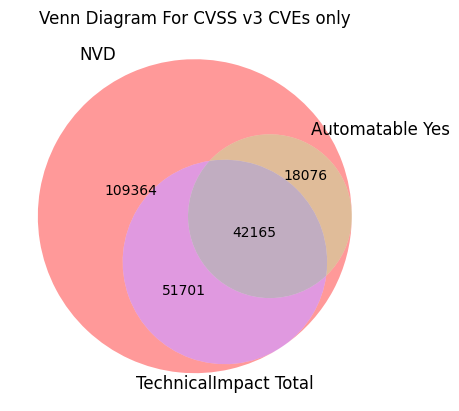

In [176]:
plt.title("Venn Diagram For CVSS v3 CVEs only")

venn3([set_cves_nvd, set_cves_automatable, set_cves_technicalimpact], ('NVD', 'Automatable Yes', 'TechnicalImpact Total'))

### Profiling

For more on how to do easy powerful EDA see https://www.youtube.com/watch?v=oMZN810xfck&t=1004s

## Calculate the Decision from the Decision Node Values

Since we are doing a first pass triage, and not calculating the Asset/Mission impact for a specific asset, we'll show the Decision for all values of MissionWellBeing for a CVE.

In [178]:
cve_list_df_mission = pd.merge(cve_list_df, dt_df, on=['Exploitation','Automatable','TechnicalImpact'], how='left')

cve_list_df_mission

,cve,Published,Description,attackVector,attackComplexity,privilegesRequired,userInteraction,Scope CVSS3,confidentialityImpact,integrityImpact,...,msrc,gpz,exploit,BaseScore,Exploitation,Automatable,TechnicalImpact,Leaf,MissionWellBeing,Priority
0,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,False,5,10.0,none,no,partial,34,high,Track
1,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,False,5,10.0,none,no,partial,35,medium,Track
2,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,False,5,10.0,none,no,partial,36,low,Track
3,CVE-1999-0082,1988-11-11,CWD ~root command in ftpd allows root access.,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,False,5,10.0,active,no,partial,10,high,Attend
4,CVE-1999-0082,1988-11-11,CWD ~root command in ftpd allows root access.,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,False,5,10.0,active,no,partial,11,medium,Track
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663913,CVE-2023-41994,2024-01-10,A logic issue was addressed with improved chec...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,False,False,5,5.5,none,no,total,32,medium,Track
663914,CVE-2023-41994,2024-01-10,A logic issue was addressed with improved chec...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,False,False,5,5.5,none,no,total,33,low,Track
663915,CVE-2023-46805,2024-01-12,An authentication bypass vulnerability in the ...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,LOW,...,False,False,0,8.2,active,yes,total,1,high,Act
663916,CVE-2023-46805,2024-01-12,An authentication bypass vulnerability in the ...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,LOW,...,False,False,0,8.2,active,yes,total,2,medium,Act


### Sort CVEs by Priority and EPSS Scores

In [179]:
# Map the Priority Category to a numeric value for sorting and plotting
priority_numeric = {'Act': '1', 'Attend': '2', 'Track': '3', 'Track*': '4'}

cve_list_df_mission['priority_numeric'] = cve_list_df_mission['Priority'].map(priority_numeric)
cve_list_df_mission

,cve,Published,Description,attackVector,attackComplexity,privilegesRequired,userInteraction,Scope CVSS3,confidentialityImpact,integrityImpact,...,gpz,exploit,BaseScore,Exploitation,Automatable,TechnicalImpact,Leaf,MissionWellBeing,Priority,priority_numeric
0,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,5,10.0,none,no,partial,34,high,Track,3
1,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,5,10.0,none,no,partial,35,medium,Track,3
2,CVE-1999-0095,1988-10-01,"The debug command in Sendmail is enabled, allo...",Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,5,10.0,none,no,partial,36,low,Track,3
3,CVE-1999-0082,1988-11-11,CWD ~root command in ftpd allows root access.,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,5,10.0,active,no,partial,10,high,Attend,2
4,CVE-1999-0082,1988-11-11,CWD ~root command in ftpd allows root access.,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,Missing_Data,...,False,5,10.0,active,no,partial,11,medium,Track,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663913,CVE-2023-41994,2024-01-10,A logic issue was addressed with improved chec...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,32,medium,Track,3
663914,CVE-2023-41994,2024-01-10,A logic issue was addressed with improved chec...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,33,low,Track,3
663915,CVE-2023-46805,2024-01-12,An authentication bypass vulnerability in the ...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,LOW,...,False,0,8.2,active,yes,total,1,high,Act,1
663916,CVE-2023-46805,2024-01-12,An authentication bypass vulnerability in the ...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,LOW,...,False,0,8.2,active,yes,total,2,medium,Act,1


In [180]:
# Sort by Priority and EPSS score 
cve_list_df_mission.sort_values(['priority_numeric','epss'], ascending=[True, False], inplace=True)

cve_list_df_mission


,cve,Published,Description,attackVector,attackComplexity,privilegesRequired,userInteraction,Scope CVSS3,confidentialityImpact,integrityImpact,...,gpz,exploit,BaseScore,Exploitation,Automatable,TechnicalImpact,Leaf,MissionWellBeing,Priority,priority_numeric
347184,CVE-2019-2725,2019-04-26,Vulnerability in the Oracle WebLogic Server co...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,1,high,Act,1
347185,CVE-2019-2725,2019-04-26,Vulnerability in the Oracle WebLogic Server co...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,2,medium,Act,1
295209,CVE-2018-7600,2018-03-29,"Drupal before 7.58, 8.x before 8.3.9, 8.4.x be...",NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,1,high,Act,1
295210,CVE-2018-7600,2018-03-29,"Drupal before 7.58, 8.x before 8.3.9, 8.4.x be...",NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,2,medium,Act,1
192654,CVE-2014-6271,2014-09-24,GNU Bash through 4.3 processes trailing string...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,1,high,Act,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663900,CVE-2023-40430,2024-01-10,A logic issue was addressed with improved chec...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,31,high,Track*,4
663903,CVE-2023-40411,2024-01-10,This issue was addressed with improved data pr...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,31,high,Track*,4
663906,CVE-2023-42826,2024-01-10,The issue was addressed with improved checks. ...,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,...,False,5,7.8,none,no,total,31,high,Track*,4
663909,CVE-2023-41987,2024-01-10,This issue was addressed with improved checks....,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,31,high,Track*,4


In [181]:
#cve_list_df_mission.to_csv('./data/nvd_cves_enriched_mission_decisions.csv.gz', compression="gzip")

# Plots

### Plot CVSS baseScore vs EPSS with Priority as Color


Text(0.5, 0.98, 'CVSS baseScore vs EPSS with Priority as Color for all CVEs')

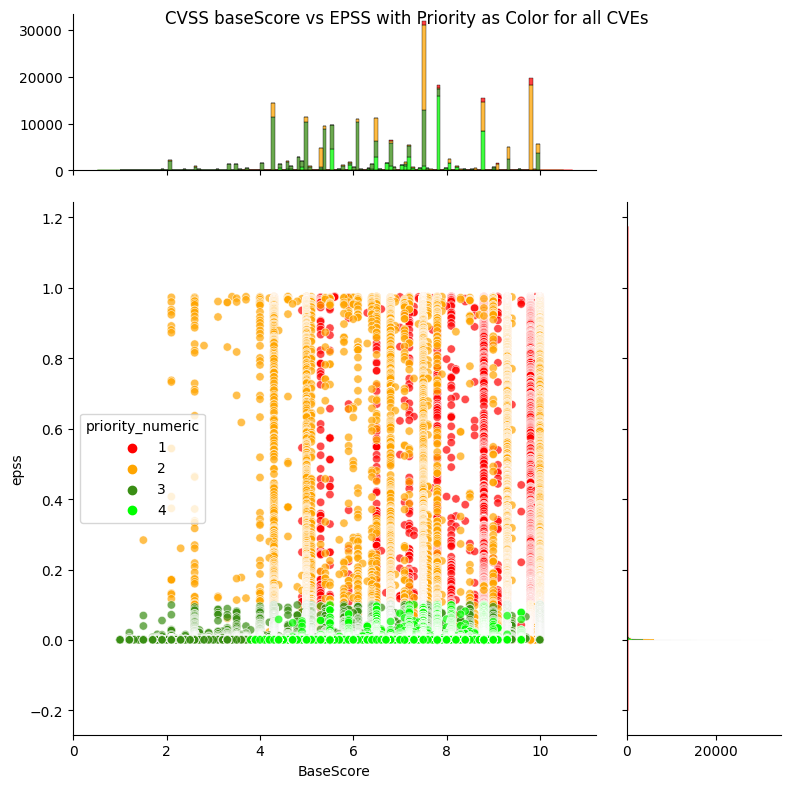

In [182]:
cve_list_df_MissionWellBeing_high = cve_list_df_mission[cve_list_df_mission['MissionWellBeing'] == "high"]


palette1 = ["#ff0000", "#ffa500", "#398e14", "#00ff00"]

g=sns.jointplot(data=cve_list_df_MissionWellBeing_high, x="BaseScore", y="epss", kind='scatter', height=8, ratio=3, marginal_ticks=True, alpha=.7, hue="priority_numeric", palette=palette1)
g.plot_marginals(sns.histplot, multiple="stack")
g.fig.suptitle('CVSS baseScore vs EPSS with Priority as Color for all CVEs')

### Plot CVSS baseScore vs EPSS with Priority as Color for EPSS >= 0.1 for all CVEs
So we can see more detail


/Users/cmadden01/work/vulnerability_scoring/vulnerability_scoring/lib/python3.10/site-packages/seaborn/axisgrid.py:1826: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.

/Users/cmadden01/work/vulnerability_scoring/vulnerability_scoring/lib/python3.10/site-packages/seaborn/axisgrid.py:1877: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.

/Users/cmadden01/work/vulnerability_scoring/vulnerability_scoring/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.

/Users/cmadden01/work/vulnerability_scoring/vulnerability_scoring/lib/python3.10/site-packages/seaborn/axisgrid.py:1877: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.

/Users/cmadden01/work/vulnerability_scoring/vulnerability_scoring/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning

Text(0.5, 0.98, 'CVSS baseScore vs EPSS (EPSS >= 0.1) with Priority as Color for all CVEs')

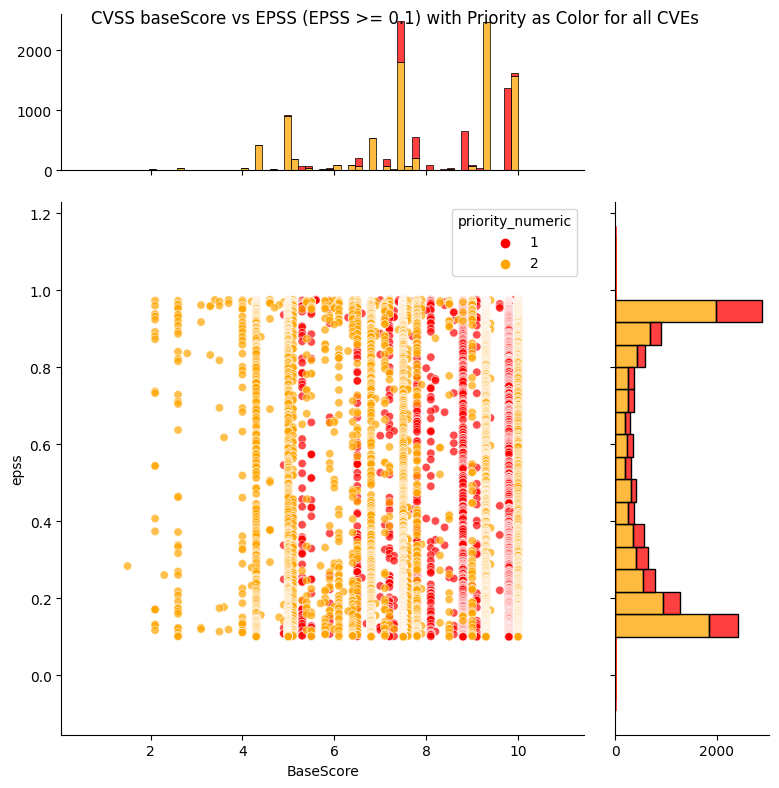

In [200]:
cve_list_df_MissionWellBeing_high_epss01 = cve_list_df_MissionWellBeing_high[cve_list_df_MissionWellBeing_high['epss'] >= 0.1]
g=sns.jointplot(data=cve_list_df_MissionWellBeing_high_epss01, x="BaseScore", y="epss", kind='scatter', height=8, ratio=3, marginal_ticks=True, alpha=.7, hue="priority_numeric", palette=palette1)
g.plot_marginals(sns.histplot, multiple="stack")
g.fig.suptitle('CVSS baseScore vs EPSS (EPSS >= 0.1) with Priority as Color for all CVEs')

# Plot Flow of All CVES across the Decision Tree 
Sankey
3 x 2 x 2 x 3 = 36 leaves
* 3 Exploitation
* 2 Automatable
* 2 Technical Impact
* 3 Mission & Well-being

1 + 3 + 6 + 12 = 20 Decison Nodes excluding Mission & Well-being

Starting at the end leaves, count the leaves for each decision node,


In [184]:
df_leaf_count = pd.DataFrame(columns=['leaf_count'], index=range(37)) 
df_leaf_count['leaf_count'] = cve_list_df_mission.Leaf.value_counts()
df_leaf_count['leaf_count'].fillna(0, inplace=True)
df_leaf_count.drop(index=0, inplace=True)
df_leaf_count


,leaf_count
1,2670.0
2,2670.0
3,2670.0
4,364.0
5,364.0
6,364.0
7,1863.0
8,1863.0
9,1863.0
10,10107.0


In [185]:
# Take every 3rd leaf count (as Mission & Well-being has 3 nodes)
df_impact_count = df_leaf_count.iloc[::3]
df_impact_count.reset_index(inplace=True)
df_impact_count

,index,leaf_count
0,1,2670.0
1,4,364.0
2,7,1863.0
3,10,10107.0
4,13,0.0
5,16,0.0
6,19,0.0
7,22,0.0
8,25,39495.0
9,28,17712.0


In [186]:
# Sanity check we have the same number of CVEs per NVD CVSS v3 file
df_impact_count.leaf_count.sum()

221306.0

In [187]:
df_automatable_count = pd.DataFrame(columns=['leaf_count'], index=range(6)) 
df_automatable_count['leaf_count'] = df_impact_count.groupby(df_impact_count.index // 2)['leaf_count'].sum()
df_automatable_count

,leaf_count
0,3034.0
1,11970.0
2,0.0
3,0.0
4,57207.0
5,149095.0


In [188]:
df_exploitation_count = pd.DataFrame(columns=['leaf_count'], index=range(3)) 
df_exploitation_count['leaf_count'] = df_automatable_count.groupby(df_automatable_count.index // 2)['leaf_count'].sum()
df_exploitation_count

,leaf_count
0,15004.0
1,0.0
2,206302.0


In [189]:
df_dummy = pd.DataFrame(columns=['leaf_count'], index=range(1)) 
df_dummy['leaf_count']=0
df_dt_counts=pd.concat([df_dummy, df_exploitation_count], ignore_index=True, sort=False)
df_dt_counts=pd.concat([df_dt_counts, df_automatable_count], ignore_index=True, sort=False)
df_dt_counts=pd.concat([df_dt_counts, df_impact_count], ignore_index=True, sort=False)
df_dt_counts
    


,leaf_count,index
0,0.0,NaN
1,15004.0,NaN
2,0.0,NaN
3,206302.0,NaN
4,3034.0,NaN
5,11970.0,NaN
6,0.0,NaN
7,0.0,NaN
8,57207.0,NaN
9,149095.0,NaN


In [190]:
# Draw a sankey diagram given a sankey dataframe
#https://plotly.com/python/sankey-diagram/
def dt_sankey (sankey_df, diagram_title, filename="../images/sankey.png"):

  labels=sankey_df['Node, Label'].dropna(axis=0, how='any')
  colors = sankey_df['Color']
  sankey_df=sankey_df.iloc[1:, :]
  link_colors=sankey_df['Color']
  sankey_df

  data_trace = dict(
      type='sankey',
      domain = dict(
        x =  [0,1],
        y =  [0,1]
      ),
      orientation = "h",
      valueformat = ".0f",
      node = dict(
        pad = 20,
        thickness = 15,
        line = dict(
          color = "black",
          width = 0.5
        ),
        label =  labels,
        color = colors
      ),
      link = dict(
        source = sankey_df['Source'].dropna(axis=0, how='any'),
        target = sankey_df['Target'].dropna(axis=0, how='any'),
        value = sankey_df['Value'].dropna(axis=0, how='any'),
        color = sankey_df['Color'].dropna(axis=0, how='any')
    )
  )

  layout =  dict(
      title = diagram_title,
      height = 900,
      width = 950,
      font = dict(
        size = 10
      ),    
  )


  fig = dict(data=[data_trace], layout=layout)
  pio.write_image(file=filename, fig=fig)
  pio.show(fig)
  

In [191]:
# Use a Sankey diagram template that has the source-target links, titles, and colors setup 
sankey_df = pd.read_csv('./DT_sankey.csv')
sankey_df['Value']=df_dt_counts['leaf_count']
sankey_df

,Unnamed: 0,Source,Target,Value,Color,"Node, Label"
0,0,0,0,0.0,#fd8e3c,All CVEs
1,1,0,1,15004.0,#e31a1c,Exploitation - Active
2,2,0,2,0.0,#fd8e3c,Exploitation - Poc
3,3,0,3,206302.0,#fed977,Exploitation - None Known
4,4,1,4,3034.0,#b00026,Automatable - Yes
5,5,1,5,11970.0,#ed2e21,Automatable - No
6,6,2,6,0.0,#fc5b2e,Automatable - Yes
7,7,2,7,0.0,#feab49,Automatable - No
8,8,3,8,57207.0,#feca66,Automatable - Yes
9,9,3,9,149095.0,#fff1a9,Automatable - No


In [192]:
dt_sankey(sankey_df, "All CVEs DT Sankey Diagram")

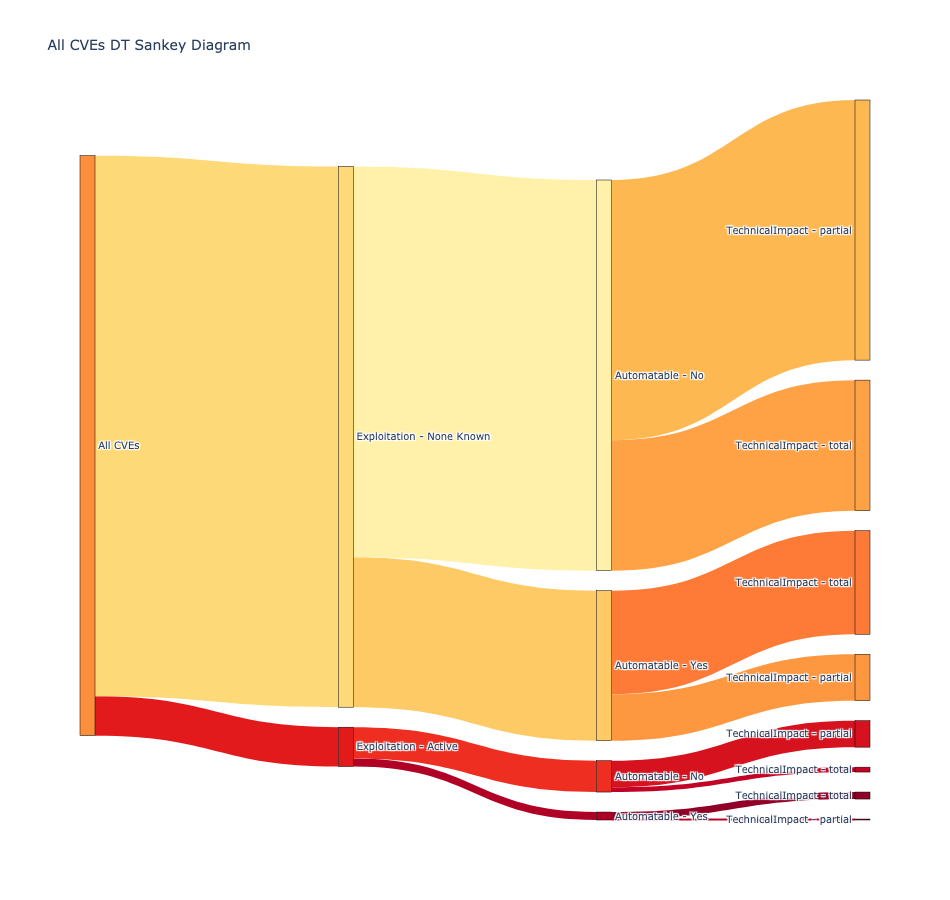

In [193]:
# Show static Sankey image in github
Image(filename='../images/sankey.png') 

# Get a list of Vulnerabilities to triage

An arbitrary list of CVEs is used - this can be 1 or many CVEs

In [194]:
## Vulnerabilities with CVEs to Triage
cves2triage_df = pd.read_csv('./triage/cves2triage.csv', names=['cve'])
cves2triage_df

,cve
0,CVE-2022-0004
1,CVE-2022-0005
2,CVE-2022-0010
3,CVE-2022-4953
4,CVE-2022-4955
5,CVE-2022-0543
6,CVE-2022-0609
7,CVE-2022-0847
8,CVE-2022-1040
9,CVE-2018-14064


## Add Enrichment Data to the CVEs to Triage

[Pandas Merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) is an easy powerful way to merge dataframes. 
* In this case, we take our list of CVES cves2triage_df, and for every CVE in the list, we add the data from the enriched CVE dataset cve_list_df for that CVE.

In [195]:
cves2triage_ranked_df = pd.merge(cves2triage_df, cve_list_df_mission, on='cve', how='left')
cves2triage_ranked_df

,cve,Published,Description,attackVector,attackComplexity,privilegesRequired,userInteraction,Scope CVSS3,confidentialityImpact,integrityImpact,...,gpz,exploit,BaseScore,Exploitation,Automatable,TechnicalImpact,Leaf,MissionWellBeing,Priority,priority_numeric
0,CVE-2022-0004,2022-05-12,Hardware debug modes and processor INIT settin...,PHYSICAL,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,5,6.8,none,no,total,32,medium,Track,3
1,CVE-2022-0004,2022-05-12,Hardware debug modes and processor INIT settin...,PHYSICAL,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,5,6.8,none,no,total,33,low,Track,3
2,CVE-2022-0004,2022-05-12,Hardware debug modes and processor INIT settin...,PHYSICAL,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,5,6.8,none,no,total,31,high,Track*,4
3,CVE-2022-0005,2022-05-12,Sensitive information accessible by physical p...,PHYSICAL,LOW,NONE,NONE,UNCHANGED,LOW,NONE,...,False,5,2.4,none,no,partial,34,high,Track,3
4,CVE-2022-0005,2022-05-12,Sensitive information accessible by physical p...,PHYSICAL,LOW,NONE,NONE,UNCHANGED,LOW,NONE,...,False,5,2.4,none,no,partial,35,medium,Track,3
5,CVE-2022-0005,2022-05-12,Sensitive information accessible by physical p...,PHYSICAL,LOW,NONE,NONE,UNCHANGED,LOW,NONE,...,False,5,2.4,none,no,partial,36,low,Track,3
6,CVE-2022-0010,2023-05-22,Insertion of Sensitive Information into Log Fi...,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,32,medium,Track,3
7,CVE-2022-0010,2023-05-22,Insertion of Sensitive Information into Log Fi...,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,33,low,Track,3
8,CVE-2022-0010,2023-05-22,Insertion of Sensitive Information into Log Fi...,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,...,False,5,5.5,none,no,total,31,high,Track*,4
9,CVE-2022-4953,2023-08-14,The Elementor Website Builder WordPress plugin...,NETWORK,LOW,NONE,REQUIRED,CHANGED,LOW,LOW,...,False,5,6.1,none,no,partial,34,high,Track,3


## Sort by Priority and EPSS score 



In [196]:
# Sort by Priority and EPSS score 
cves2triage_ranked_df.sort_values(['priority_numeric','epss'], ascending=[True, False], inplace=True)
cves2triage_ranked_df

,cve,Published,Description,attackVector,attackComplexity,privilegesRequired,userInteraction,Scope CVSS3,confidentialityImpact,integrityImpact,...,gpz,exploit,BaseScore,Exploitation,Automatable,TechnicalImpact,Leaf,MissionWellBeing,Priority,priority_numeric
33,CVE-2020-14750,2020-11-02,Vulnerability in the Oracle WebLogic Server pr...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,1,high,Act,1
34,CVE-2020-14750,2020-11-02,Vulnerability in the Oracle WebLogic Server pr...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,2,medium,Act,1
15,CVE-2022-0543,2022-02-18,"It was discovered, that redis, a persistent ke...",NETWORK,LOW,NONE,NONE,CHANGED,HIGH,HIGH,...,False,0,10.0,active,yes,total,1,high,Act,1
16,CVE-2022-0543,2022-02-18,"It was discovered, that redis, a persistent ke...",NETWORK,LOW,NONE,NONE,CHANGED,HIGH,HIGH,...,False,0,10.0,active,yes,total,2,medium,Act,1
24,CVE-2022-1040,2022-03-25,An authentication bypass vulnerability in the ...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,True,0,9.8,active,yes,total,1,high,Act,1
25,CVE-2022-1040,2022-03-25,An authentication bypass vulnerability in the ...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,True,0,9.8,active,yes,total,2,medium,Act,1
30,CVE-2018-8373,2018-08-15,A remote code execution vulnerability exists i...,NETWORK,HIGH,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,...,True,0,7.5,active,no,total,7,high,Act,1
45,CVE-2023-28771,2023-04-25,Improper error message handling in Zyxel ZyWAL...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,1,high,Act,1
46,CVE-2023-28771,2023-04-25,Improper error message handling in Zyxel ZyWAL...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,...,False,0,9.8,active,yes,total,2,medium,Act,1
36,CVE-2020-14864,2020-10-21,Vulnerability in the Oracle Business Intellige...,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,NONE,...,False,0,7.5,active,yes,total,1,high,Act,1


### Priority vs EPSS
It's good to use both the Priority Decision (Static) and EPSS Score (Temporal) together.

Here we show CVEs by Priority Decision (Static) and EPSS Score via a table and a plot.


Text(0.5, 0.98, 'CVSS baseScore vs EPSS with Priority as Color for a sample of CVEs')

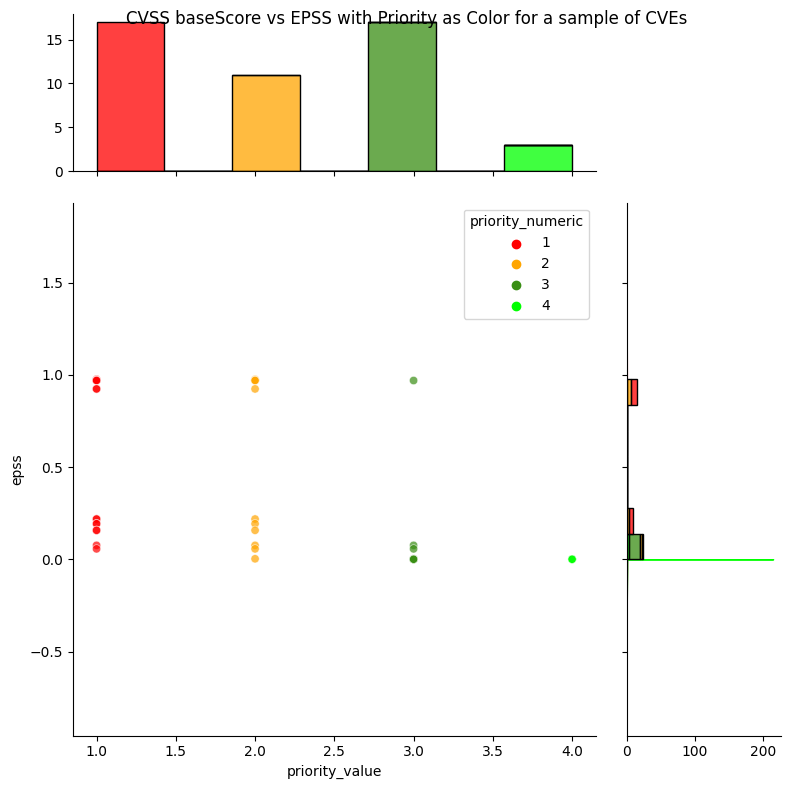

In [197]:
cves2triage_ranked_df["priority_value"]=cves2triage_ranked_df["priority_numeric"].astype("int")
g=sns.jointplot(data=cves2triage_ranked_df, x='priority_value', y="epss", kind='scatter', height=8, ratio=3, marginal_ticks=True, alpha=.7, hue="priority_numeric", palette=palette1)
g.plot_marginals(sns.histplot, multiple="stack")
g.fig.suptitle('CVSS baseScore vs EPSS with Priority as Color for a sample of CVEs')

# Conclusion

1. You can build an Enriched CVE dataset using public free data - and use it with SSVC, CVSS, other....
   1. (Commercial Cyber Threat Intel vendors **may** include more data than the data sources used here - but don't assume their data is better than what we've used here!)
   2. If you have a Commercial Cyber Threat Intel vendor, you can use that data.
2. The code to build a DT, and use it to triage CVEs, is simple!
3. It's good to use both the Priority Decision (Static) and EPSS Score (Temporal) together.
   1. Here we show CVEs by Priority Decision (Static) and EPSS Score via a table and a plot.
4. You can use this with your CVEs to build your own DT with
   1. EPSS thresholds for your data
   2. DT Decision Node logic


# Things not done

### Vulnerabilities without CVEs
This is very easy to support - either at:
1. DT Decision Node Outputs: Exploitation, Automatability, TechnicalImpact --> Priority Decision Node
2. CVSS Base Score Parameters: attackComplexity, attackVector, userInteraction, privilegesRequired, confidentialityImpact, integrityImpact, availabilityImpact ->  DT Decision Node Outputs -> Priority
   1. When we have a CVE, this is all we're using it for i.e. to get these Base Score Parameters. 

### Split out "Act" top 2 DT nodes into "Act ASAP"
Per https://youtu.be/oMZN810xfck?t=1334, I care most about the highest risk vulnerabilties - so I split out the top 2 Act nodes to Act ASAP - so I get an extra high priority level.